In [10]:
import os
import time
from pathlib import Path
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split

import torcheeg
from torcheeg import transforms
from torcheeg.io import MetaInfoIO

import mne

from sklearn.metrics import f1_score

import tools

device = "cuda"; seed = 42; tools.seed_everything(seed)

# Dataset

In [2]:
import datasets

DATASET_NAME ='GAMEEMO'

channel_list  = ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8'] 

subnum = 28; sampling_rate = 128; low_freq=0.16; high_freq=43;
band_dict = {'theta':[4,8], 'alpha':[8,14],'beta':[14,31],'gamma':[31,high_freq]}

In [3]:
preprocessed_path = f'/mnt/data/members/granularity/{DATASET_NAME}_raw__14_256'
dataset = datasets.GAMEEMODataset(io_path = preprocessed_path,
            online_transform = transforms.Compose([transforms.ToTensor()]),
            label_transform  = transforms.Compose([transforms.Select(key=['valence', 'arousal']),
                                                  tools.ListToTensor()]) )
dataset.info

dataset already exists at path /mnt/data/members/granularity/GAMEEMO_raw__14_256, reading from path...


,start_at,end_at,clip_id,subject_id,trial_id,emotion,valence,arousal,_record_id
0,7680,7936,S01G1AllChannels.csv_0,1,1,0,2,3,_record_0
1,7808,8064,S01G1AllChannels.csv_1,1,1,0,2,3,_record_0
2,7936,8192,S01G1AllChannels.csv_2,1,1,0,2,3,_record_0
3,8064,8320,S01G1AllChannels.csv_3,1,1,0,2,3,_record_0
4,8192,8448,S01G1AllChannels.csv_4,1,1,0,2,3,_record_0
...,...,...,...,...,...,...,...,...,...
6379,14336,14592,S28G4AllChannels.csv_223,28,4,3,7,3,_record_27
6380,14464,14720,S28G4AllChannels.csv_224,28,4,3,7,3,_record_27
6381,14592,14848,S28G4AllChannels.csv_225,28,4,3,7,3,_record_27
6382,14720,14976,S28G4AllChannels.csv_226,28,4,3,7,3,_record_27


In [4]:
sample = dataset[0][0]
sample.shape

torch.Size([14, 256])

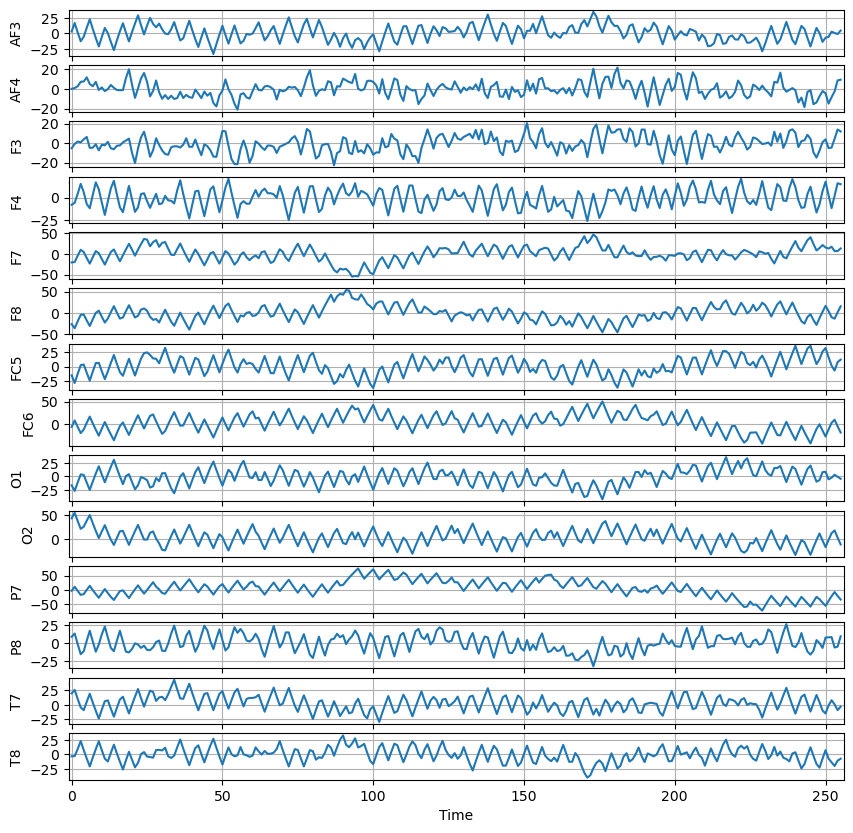

In [5]:
def plot_signal(data, channel_list):
    plt.figure(figsize=(10, 10))  
    for i, channel in enumerate(channel_list):
        plt.subplot(14, 1, i+1) 
        plt.plot(torch.arange(256), data[i], label=channel)
        plt.ylabel(channel);
        plt.xlabel('Time');  plt.grid(True); plt.xlim(-1, 256)
    plt.show()
plot_signal(sample, channel_list)

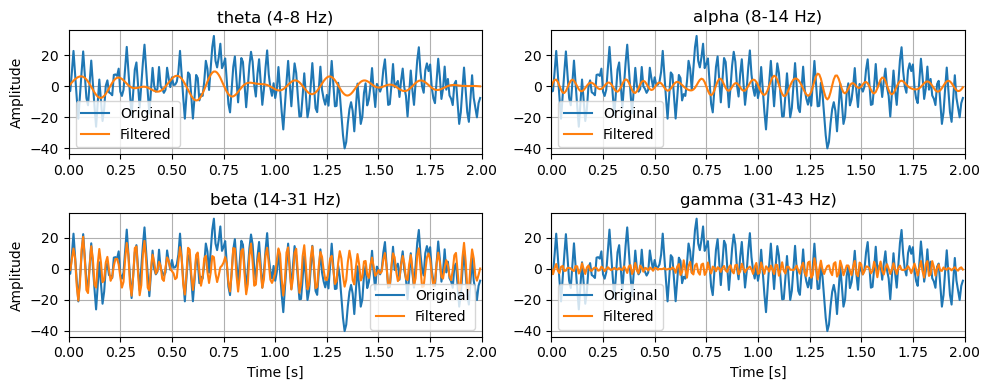

In [6]:
from scipy import signal
def plot_filtered_bands(x, fs, band_dict):
    plt.figure(figsize=(10, 4))  # 전체 그래프 크기 설정
    for i, (band_name, (lowcut, highcut)) in enumerate(band_dict.items(), start=1):
        b, a = signal.butter(5, [lowcut/(fs/2), highcut/(fs/2)], btype='band')
        filtered_signal = signal.filtfilt(b, a, x)
        t = np.linspace(0, (len(x)-1)/fs, len(x))
        ax = plt.subplot(2, 2, i)  # 2x2 그리드에 서브플롯 배치
        ax.plot(t, x, label='Original')
        ax.plot(t, filtered_signal, label=f'Filtered')
        ax.set_title(f'{band_name} ({lowcut}-{highcut} Hz)')
        if i==3 or i==4: ax.set_xlabel('Time [s]');
        if i==1 or i==3: ax.set_ylabel('Amplitude')
        plt.xlim(0, 2); ax.legend(); ax.grid(True)
    plt.tight_layout(); plt.show()
plot_filtered_bands(sample[-1], sampling_rate, band_dict)

# Split train test

In [7]:
import model_selection

split_path = os.path.join(os.path.dirname(preprocessed_path), f'{DATASET_NAME}__256_LOSO')
cv = model_selection.LeaveOneSubjectOut(split_path=split_path, info=dataset.info)

already in splt_path = /mnt/data/members/granularity/GAMEEMO__256_LOSO


In [8]:
def print_unique_count(dataset, subject):
    print(f'Test subject ID = {subject}')
    trainset, testset = cv.split(dataset, subject)
    for dimension in ['valence', 'arousal']:
        print(dimension, 'samples:', len(trainset), len(testset))
        train_unique = sorted(trainset.info[dimension].unique())
        test_unique = sorted(testset.info[dimension].unique())
        train_counts = trainset.info[dimension].value_counts().to_dict()
        test_counts = testset.info[dimension].value_counts().to_dict()
        print('  Train Labels:', train_unique); print('   ', train_counts); 
        print('  Test  Labels:', test_unique); print('   ', test_counts);
print_unique_count(dataset, subject=9)

Test subject ID = 9
valence samples: 6156 228
  Train Labels: [1, 2, 3, 4, 5, 6, 7, 8, 9]
    {7: 1026, 5: 912, 3: 855, 2: 741, 4: 684, 1: 627, 9: 627, 6: 399, 8: 285}
  Test  Labels: [3, 5]
    {5: 171, 3: 57}
arousal samples: 6156 228
  Train Labels: [1, 2, 3, 4, 5, 6, 7, 8, 9]
    {5: 969, 3: 855, 4: 855, 7: 855, 6: 741, 9: 570, 1: 570, 2: 513, 8: 228}
  Test  Labels: [1, 5, 7]
    {1: 114, 5: 57, 7: 57}


## Data Scaling

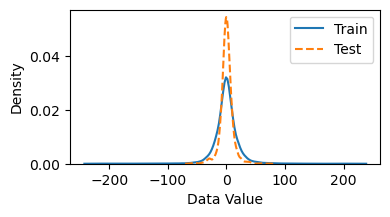

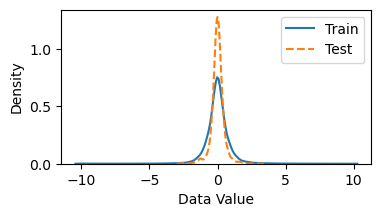

In [9]:
def get_x_from_dataset(dataset):
    x_samples = np.array([dataset[i][0].numpy() for i in range(len(dataset))])
    return x_samples

def calculate_stats(dataset):
    x_samples = get_x_from_dataset(dataset)
    mean, std = np.mean(x_samples, axis=0), np.std(x_samples, axis=0)    
    return mean, std  

def plot_value_density(train_samples, test_samples):
    plt.figure(figsize=(4,2))
    sns.kdeplot(train_samples[:, 5, :10].flatten(), label=f"Train", linestyle="-", color=f"C0")
    sns.kdeplot(test_samples[:, 5, :10].flatten(), label=f"Test", linestyle="--", color=f"C1")
    plt.xlabel('Data Value'); #plt.xlim(-5,5)
    plt.ylabel('Density'); plt.legend(); plt.show()
    
trainset, testset = cv.split(dataset, subject=9)
plot_value_density(get_x_from_dataset(trainset), get_x_from_dataset(testset))
train_mean, train_std = calculate_stats(trainset)
trainset.online_transform = transforms.Compose([tools.MeanStdNormalize(train_mean, train_std), transforms.ToTensor()])
testset.online_transform  = transforms.Compose([tools.MeanStdNormalize(train_mean, train_std), transforms.ToTensor()])
plot_value_density(get_x_from_dataset(trainset), get_x_from_dataset(testset))

In [10]:
# trainset.online_transform = transforms.Compose([tools.MeanStdNormalize(train_mean, train_std), transforms.ToTensor(), transforms.To2d()])

# Model

In [11]:
import models

MODEL_NAME ='LGGNet'
num_electrodes=dataset[0][0].shape[0]; chunk_size=dataset[0][0].shape[-1]; dropout=0.5; 
Model = models.LGGNet(region_list=datasets.GAMEEMO_GENERAL_REGION_LIST, num_electrodes=num_electrodes,
                 chunk_size=chunk_size, sampling_rate=sampling_rate, dropout=dropout)
print(Model)

LGGNet(
  (t_block1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(1, 64), stride=(1, 1))
    (1): PowerLayer(
      (pooling): AvgPool2d(kernel_size=(1, 16), stride=(1, 4), padding=0)
    )
  )
  (t_block2): Sequential(
    (0): Conv2d(1, 64, kernel_size=(1, 32), stride=(1, 1))
    (1): PowerLayer(
      (pooling): AvgPool2d(kernel_size=(1, 16), stride=(1, 4), padding=0)
    )
  )
  (t_block3): Sequential(
    (0): Conv2d(1, 64, kernel_size=(1, 16), stride=(1, 1))
    (1): PowerLayer(
      (pooling): AvgPool2d(kernel_size=(1, 16), stride=(1, 4), padding=0)
    )
  )
  (bn_t1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_t2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cbam): CBAMBlock(
    (cha_att): ChannelAttention(
      (max_pool): AdaptiveMaxPool2d(output_size=1)
      (avg_pool): AdaptiveAvgPool2d(output_size=1)
      (fc1): Conv2d(14, 7, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (rel

# Learning

In [12]:
# 회귀 기반 분류
## 회귀 모델 -> 연속적인 값 -> 분류 결정
## RMSE: valence, arousal, valence-arousal (두 차원 모두에 대해)
## Accuracy: valence, arousal, valence-arousal 

In [13]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__() 
        self.loss_fn = nn.MSELoss()
    def forward(self, y_pred, y):
        loss1 = self.loss_fn(y_pred[:, 0], y[:, 0]) 
        loss2 = self.loss_fn(y_pred[:, 1], y[:, 1]) 
        return torch.sqrt(loss1)*0.6 + torch.sqrt(loss2)*0.4

def to_categorical(y_pred):
    categories = torch.zeros_like(y_pred)
    categories[y_pred < 4] = 0
    categories[(y_pred >= 4) & (y_pred <= 6)] = 1
    categories[y_pred > 6] = 2
    return categories

In [14]:
def train(dataloader, model, loss_fn, optimizer, device):
    epoch_loss, epoch_correct = 0, 0
    model.train()
    for (x, y) in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward(); optimizer.step()
        epoch_loss += loss.item()
        correct = torch.all(to_categorical(y_pred)==to_categorical(y), dim=1).sum().item()
        epoch_correct += correct
    epoch_loss /= len(dataloader); epoch_correct /= len(dataloader.dataset)
    return round(epoch_loss, 4), round(100 * epoch_correct, 2)

def test(dataloader, model, device):
    correct = 0; loss = 0; n_samples = len(dataloader.dataset)
    val_loss, aro_loss = 0.0, 0.0; val_correct, aro_correct = 0, 0
    model.eval()
    with torch.no_grad():
        for (x, y) in dataloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss += nn.functional.mse_loss(y_pred.view(-1), y.view(-1), reduction='sum').item()
            val_loss += nn.functional.mse_loss(y_pred[:, 0], y[:, 0], reduction='sum').item()
            aro_loss += nn.functional.mse_loss(y_pred[:, 1], y[:, 1], reduction='sum').item() 
            correct += torch.all(to_categorical(y_pred)==to_categorical(y), dim=1).sum().item()
            val_correct += (to_categorical(y_pred)[:, 0]==to_categorical(y)[:, 0]).sum().item()
            aro_correct += (to_categorical(y_pred)[:, 1]==to_categorical(y)[:, 1]).sum().item()
    loss = np.sqrt(loss / n_samples)
    val_loss = np.sqrt(val_loss / n_samples); aro_loss = np.sqrt(aro_loss / n_samples)
    acc = 100 * (correct / n_samples)
    val_acc = 100 * (val_correct / n_samples); aro_acc = 100 * (aro_correct / n_samples)
    return {'loss': round(loss, 4), 'acc': round(acc, 2),
            'val_RMSE': round(val_loss, 4), 'aro_RMSE': round(aro_loss, 4),
            'val_acc': round(val_acc, 2), 'aro_acc': round(aro_acc, 2)}
    
def plot_train_log(train_losses, train_accs, path=os.getcwd(), flag=1):
    fig, loss_ax = plt.subplots(figsize=(10,4))
    acc_ax = loss_ax.twinx()
    xran = range(1, len(train_losses)+1)
    loss_ax.plot(xran, train_losses, 'y', label = 'train loss')
    acc_ax.plot(xran, train_accs, 'b', label = 'train ACC')
    loss_ax.set_xlabel('epoch'); loss_ax.set_ylabel('Loss'); acc_ax.set_ylabel('Accuracy')
    loss_ax.legend(loc='upper left'); acc_ax.legend(loc='lower left')
    plt.grid(True); plt.tight_layout()
    plt.savefig(os.path.join(path, f'train_log_{flag}.png'))

In [15]:
EXPER_SET = 'SI_VA';
exper_path = os.path.join(os.getcwd(), "OUT", f'{DATASET_NAME} {EXPER_SET}')
exper_model_path = os.path.join(exper_path, f'{MODEL_NAME}')

def run_train(subject):
    print(f'Test Subject ID = {subject}======================================================')
    result_path = Path(os.path.join(exper_model_path, str(subject)))
    result_path.mkdir(parents=True, exist_ok=True)
    
    start = time.monotonic()
    trainset, testset = cv.split(dataset, subject)
    train_mean, train_std = calculate_stats(trainset)
    trainset.online_transform = transforms.Compose([tools.MeanStdNormalize(train_mean, train_std), transforms.ToTensor(), transforms.To2d()])
    testset.online_transform = transforms.Compose([tools.MeanStdNormalize(train_mean, train_std), transforms.ToTensor(), transforms.To2d()])
    train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    model = copy.deepcopy(Model).to(device)
    loss_fn = CustomLoss().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.001)
    with open(os.path.join(result_path, f'train_{subject}.txt'), 'w') as f:
        f.write(f'[train test] [{len(trainset)} {len(testset)}] batch:{BATCH_SIZE} lr:{LR}\n'
                f'Epoch_{EPOCH}_time \t Train_Loss \t Train_ACC \n')
        print(f'\tEpoch_{EPOCH}_time \t Train_Loss \t Train_ACC ')
        train_losses, train_accs = [], []
        best_train_loss = float('inf'); best_train_acc = 0
        for epoch in range(EPOCH):
            start_time = time.monotonic()
            train_loss, train_acc = train(train_loader, model, loss_fn, optimizer, device)
            train_losses.append(train_loss); train_accs.append(train_acc)
            if train_loss < best_train_loss:
                best_train_loss = train_loss
                torch.save(model.state_dict(), os.path.join(result_path, f'best_train_{subject}.pt'))
                best_epoch = epoch
            end_time = time.monotonic(); epoch_mins, epoch_secs = tools.epoch_time(start_time, end_time)
            log = f'{epoch+1:03} {epoch_secs:2d}s \t{train_loss} \t{train_acc}'
            f.write(log+'\n'); print('\t'+log)
        plot_train_log(train_losses, train_accs, path=result_path, flag=f'{subject}')
        print(f"\tmodel weights saved in '{os.path.join(result_path, f'best_train_{subject}.pt')}")
    model.load_state_dict(torch.load(os.path.join(result_path, f'best_train_{subject}.pt')))

    result = test(test_loader, model, device)
    result['subject'] = subject; result['epoch'] = best_epoch;
    result_io = MetaInfoIO(os.path.join(result_path, f'result.csv'));  result_io.write_info(result)
    
    end = time.monotonic(); min, sec = tools.epoch_time(start, end)
    print(f'time: {min} min {sec} sec\n{result}')

In [29]:
LR = 0.001; BATCH_SIZE = 64; EPOCH = 500
# run_train(subject=3)

# Predict

In [30]:
def predict(dataloader, model, device):
    correct = 0; loss = 0; n_samples = len(dataloader.dataset)
    val_loss, aro_loss = 0.0, 0.0; val_correct, aro_correct = 0, 0
    preds, ys = [], []
    model.eval()
    with torch.no_grad():
        for (x, y) in dataloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            preds.append(y_pred.cpu().numpy()); ys.append(y.cpu().numpy())
            loss += nn.functional.mse_loss(y_pred.view(-1), y.view(-1), reduction='sum').item()
            val_loss += nn.functional.mse_loss(y_pred[:, 0], y[:, 0], reduction='sum').item()
            aro_loss += nn.functional.mse_loss(y_pred[:, 1], y[:, 1], reduction='sum').item() 
            correct += torch.all(to_categorical(y_pred)==to_categorical(y), dim=1).sum().item()
            val_correct += (to_categorical(y_pred)[:, 0]==to_categorical(y)[:, 0]).sum().item()
            aro_correct += (to_categorical(y_pred)[:, 1]==to_categorical(y)[:, 1]).sum().item()
    preds = np.concatenate(preds, axis=0); ys = np.concatenate(ys, axis=0)
    loss = np.sqrt(loss / n_samples)
    val_loss = np.sqrt(val_loss / n_samples); aro_loss = np.sqrt(aro_loss / n_samples)
    acc = 100 * (correct / n_samples)
    val_acc = 100 * (val_correct / n_samples); aro_acc = 100 * (aro_correct / n_samples)
    print({'loss': round(loss, 4), 'acc': round(acc, 2),
            'val_RMSE': round(val_loss, 4), 'aro_RMSE': round(aro_loss, 4),
            'val_acc': round(val_acc, 2), 'aro_acc': round(aro_acc, 2)})
    return preds, ys

In [31]:
def run_predict(subject):
    trainset, testset = cv.split(dataset, subject)
    print(f'Test Subject ID = {subject}\t{len(testset)} samples' )
    for dimension in ['valence', 'arousal']:
        test_unique = sorted(testset.info[dimension].unique())
        test_counts = testset.info[dimension].value_counts().to_dict()
        print(f'  {dimension} {test_unique}\t{test_counts}')
    train_mean, train_std = calculate_stats(trainset)
    testset.online_transform = transforms.Compose([tools.MeanStdNormalize(train_mean, train_std), transforms.ToTensor(), transforms.To2d()])
    test_loader = DataLoader(testset, batch_size=256, shuffle=False, num_workers=0)
    model = copy.deepcopy(Model).to(device)
    model.load_state_dict(torch.load(os.path.join(exper_model_path, str(subject), f'best_train_{subject}.pt')))
    preds, ys = predict(test_loader, model, device)
    return preds, ys, testset.info

preds, ys, test_info = run_predict(subject=3)

Test Subject ID = 3	228 samples
  valence [1, 2, 7, 9]	{1: 57, 7: 57, 2: 57, 9: 57}
  arousal [2, 5, 6, 9]	{2: 57, 5: 57, 9: 57, 6: 57}
{'loss': 2.9455, 'acc': 51.75, 'val_RMSE': 2.6008, 'aro_RMSE': 1.3825, 'val_acc': 53.95, 'aro_acc': 71.93}


In [32]:
trial_num= 4
trial_ids = torch.tensor(test_info['trial_id'])
diff = trial_ids[1:] != trial_ids[:-1] # 텐서에서 값이 변하는 지점을 찾음
changes = torch.cat([torch.tensor([True]), diff])
change_indices = torch.where(changes)[0] # 변화가 있는 지점의 인덱스를 구함
trial_counts = torch.diff(torch.cat([change_indices, torch.tensor([len(trial_ids)])]))
cut = sum(trial_counts[ : trial_num])
print(trial_counts); print(cut)

tensor([57, 57, 57, 57])
tensor(228)


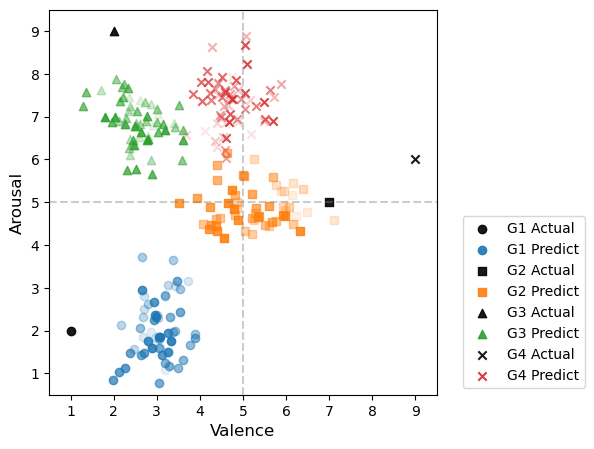

In [33]:
def predict_space(trial_counts, preds, ys):
    plt.figure(figsize=(5, 5))
    plt.axhline(y=5, color='grey', linestyle='--', alpha=0.4)
    plt.axvline(x=5, color='grey', linestyle='--', alpha=0.4)
    markers = ['o', 's', '^', 'x']
    for t, i in enumerate(trial_counts):
        s = t * i ;    e = i * (t + 1);
        alphas = np.linspace(0.1, 0.9, e - s) # 처음(연함) 끝 (진함)
        for idx, (yc, pc, alpha) in enumerate(zip(ys[s:e], preds[s:e], alphas)):
            if idx == e - s - 1:
                plt.scatter(yc[0], yc[1], color='k', alpha=0.9, marker=markers[t], label=f'G{t+1} Actual')
                plt.scatter(pc[0], pc[1], color=f'C{t}', alpha=alpha, marker=markers[t], label=f'G{t+1} Predict')
            else:
                plt.scatter(pc[0], pc[1], color=f'C{t}', alpha=alpha, marker=markers[t])
    plt.xlabel('Valence', fontsize=12); plt.ylabel('Arousal', fontsize=12)
    plt.xlim(0.5, 9.5);  plt.ylim(0.5, 9.5)
    plt.xticks(range(1, 10)); plt.yticks(range(1, 10)); 
    plt.legend(loc='lower right', bbox_to_anchor=(1.4, 0.)); plt.show()
predict_space(trial_counts, preds, ys)

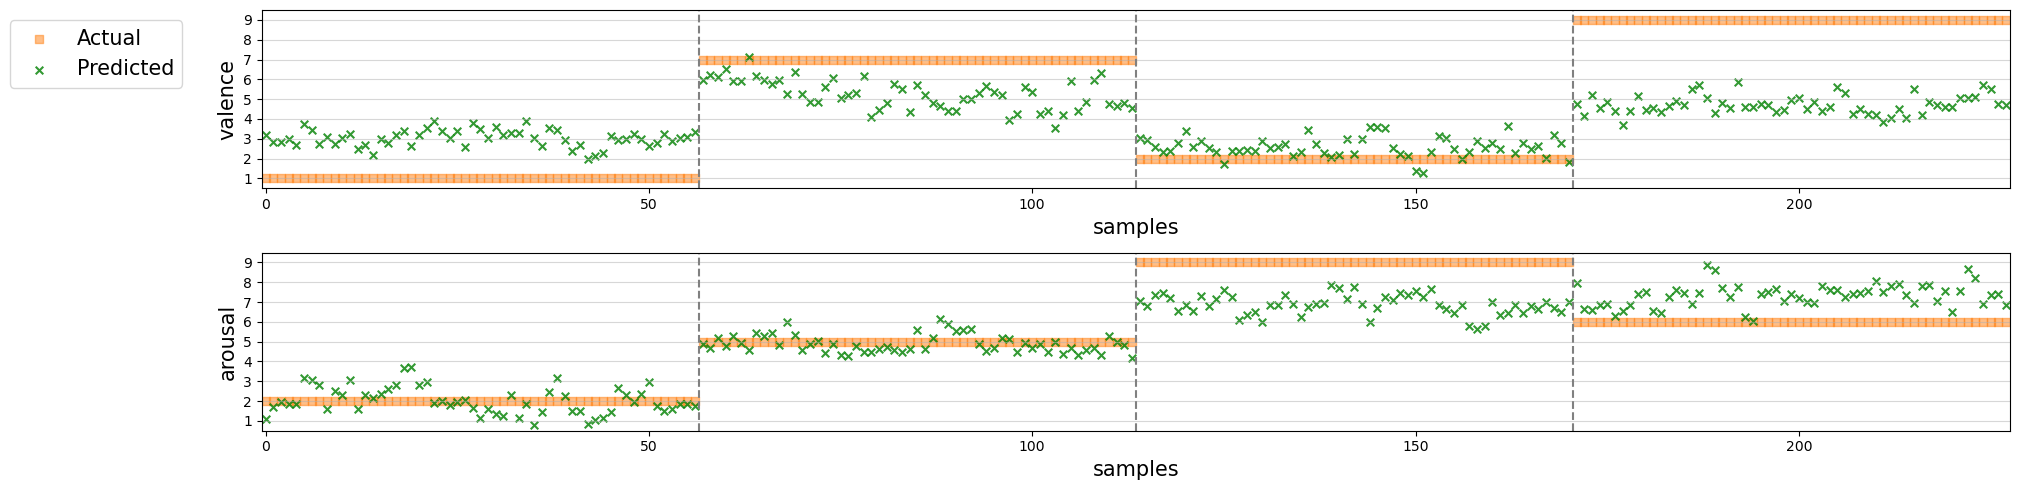

In [27]:
def predict_sample(trial_counts, preds, ys):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 5)) 
    
    trial_end = np.cumsum(trial_counts)  # 각 trial 경계에 세로 선 그리기
    for end in trial_end[:-1]:
        ax1.axvline(x=end-0.5, color='grey', linestyle='--'); ax2.axvline(x=end-0.5, color='grey', linestyle='--')
    # Valence
    ax1.scatter(np.arange(len(ys)), ys[:,0], label='Actual', color='C1', marker='s', alpha=0.5, s=30)
    ax1.scatter(np.arange(len(ys)), preds[:,0], label='Predicted', color='g', marker='x', alpha=0.8, s=30)
    # Arousal 
    ax2.scatter(np.arange(len(ys)), ys[:,1], label='Actual', color='C1', marker='s', alpha=0.5, s=30)
    ax2.scatter(np.arange(len(ys)), preds[:,1], label='Predicted', color='g', marker='x', alpha=0.8, s=30)
    
    ax1.set_yticks(range(1, 10)); ax1.set_ylim(0.5, 9.5); ax1.set_xlim(left=-0.5, right=len(ys)-0.5)
    ax2.set_yticks(range(1, 10)); ax2.set_ylim(0.5, 9.5); ax2.set_xlim(left=-0.5, right=len(ys)-0.5)
    ax1.set_ylabel('valence', fontsize=15); ax1.set_xlabel('samples', fontsize=15);
    ax2.set_ylabel('arousal', fontsize=15); ax2.set_xlabel('samples', fontsize=15);
    ax1.grid(axis='y', alpha=0.5); ax2.grid(axis='y', alpha=0.5);

    ax1.legend(loc='upper left', bbox_to_anchor=(-0.15, 1.), fontsize=15); 
    plt.tight_layout(); plt.show()
predict_sample(trial_counts, preds, ys)